In [1]:
import matplotlib.pylab as plt
import pandas as pd

/usr/local/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# loop through the sheets of the spreadsheet; each sheet is a biological replicate
# of all 3 of the biolog plates. Columns are time in hours.
reps = {}
for i in range(0,4):
    biolog_raw = pd.read_excel('../data/biolog_raw.xlsx',sheet_name="rep_"+str(i+1))
    biolog_raw.columns = [col for col in biolog_raw.columns]
    reps[i] = biolog_raw
    
all_biolog = pd.concat([reps[0],reps[1],reps[2],reps[3]])
    
# convert to mean and std at each time point, 
# and get the max OD at all time points (from means)
mets = reps[0].index.unique()
means = {}
stds = {}
maxODs = {}
for met in mets:
    vals = pd.DataFrame()
    concat_axis = 1
    if met == 'Neg':
        concat_axis = 0
    
    for rep in reps:
        vals = pd.concat([vals,reps[rep].loc[met]],axis=concat_axis)
    
    if met != 'Neg':
        vals = vals.T
    
    means[met] = vals.mean()
    stds[met] = vals.std()
    maxODs[met] = means[met].max()
    
        

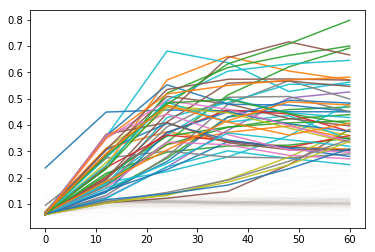

In [3]:
fig,ax = plt.subplots()
for met in means.keys():
    plotvals = means[met]
    if maxODs[met] > 0.3:
        alpha = 0.9
    else:
        alpha = 0.01
    ax.plot(plotvals.index.values,plotvals.values,alpha=alpha,label = met)

In [5]:
# threshold the growth data to get positive growth conditions only
growth_threshold = 0.3
positive_growth_conditions = {condition:maxODs[condition] for condition in maxODs.keys() if maxODs[condition] > 0.3}
phenotype_dict = pd.DataFrame.from_dict(positive_growth_conditions,orient='index')
phenotype_dict.columns = ["Max OD"]

# Read in the bioog:seed file and merge with the positive growth data to get SEED compound ids for each metabolite
biolog_to_seed = pd.read_csv('../data/biolog_names_to_seed.tsv', sep = '\t')
biolog_to_seed.index = biolog_to_seed["name"]
biolog_to_seed = biolog_to_seed.drop("name", axis=1)
carbon_sources = phenotype_dict.index.tolist()
phenotype_dict = phenotype_dict.merge(biolog_to_seed, left_index=True, right_index=True)
carbon_sources_post_merge = phenotype_dict.index.tolist()
# Print out the metabolites missing identifiers. These might be expected (e.g. pectin is a polymer that
# cannot be properly represented, so we don't include it)
print("The following compounds are missing; is this expected?", set(carbon_sources) - set(carbon_sources_post_merge))

The following compounds are missing; is this expected? {'Pectin'}
